In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from tensorflow.keras import *
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from tensorflow.keras.initializers import Constant
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [11]:
# data
tweet = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
tweet.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [13]:
print('There are {} rows and {} columns in train'.format(tweet.shape[0],tweet.shape[1]))
print('There are {} rows and {} columns in test'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in test


# class distribution

Text(0, 0.5, 'samples')

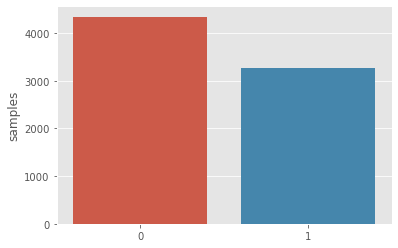

In [15]:
x = tweet.target.value_counts()
sns.barplot(x.index, x)
plt.gca().set_ylabel('samples')

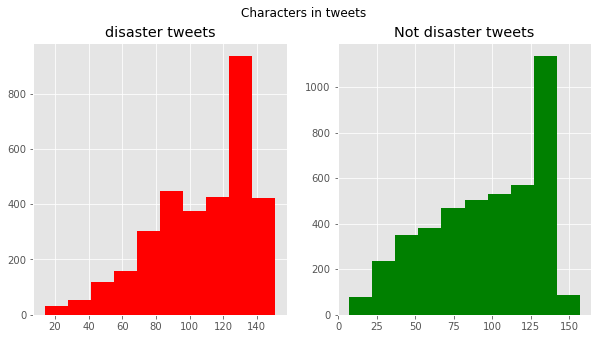

In [19]:
# Number of characters in tweets
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

tweet_len=tweet[tweet['target']==1]['text'].str.len()  # disaster
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')

tweet_len=tweet[tweet['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')

fig.suptitle('Characters in tweets')
plt.show()

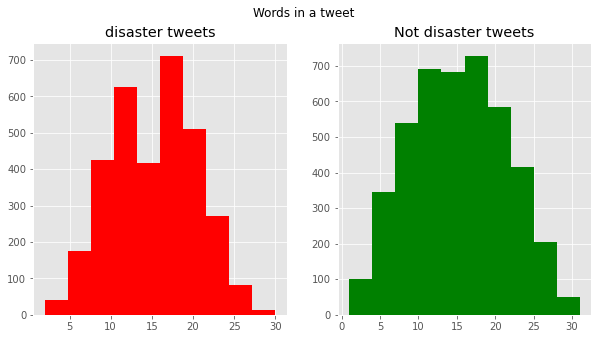

In [20]:
# Number of words in a tweet
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

tweet_len=tweet[tweet['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')

tweet_len=tweet[tweet['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')

fig.suptitle('Words in a tweet')
plt.show()

Text(0.5, 0.98, 'Average word length in each tweet')

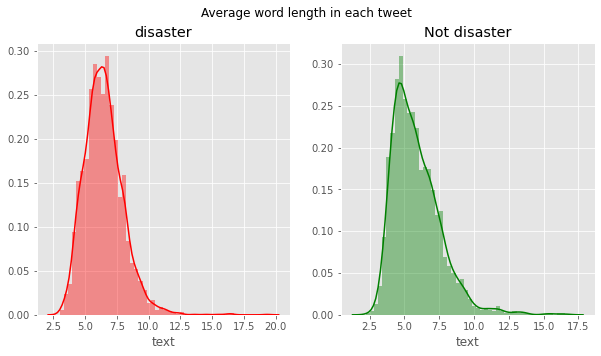

In [22]:
# Average word length in a tweet
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=tweet[tweet['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')

word=tweet[tweet['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

In [23]:
def create_corpus(target):
    corpus=[]
    
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [24]:
# Common stopwords in tweets

corpus = create_corpus(0)

dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

<BarContainer object of 10 artists>

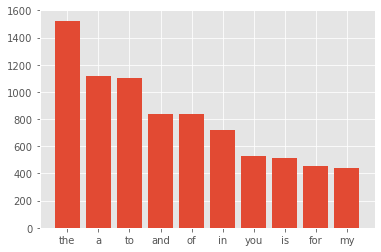

In [27]:
x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 18 artists>

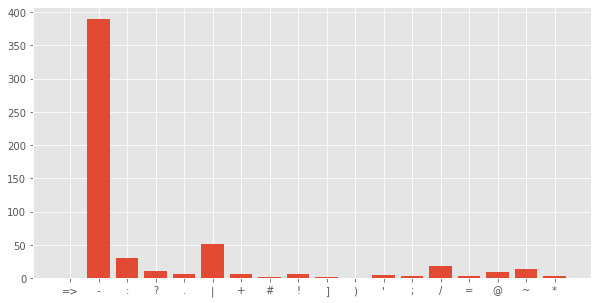

In [28]:
# punctuations
plt.figure(figsize=(10,5))
corpus=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

<BarContainer object of 20 artists>

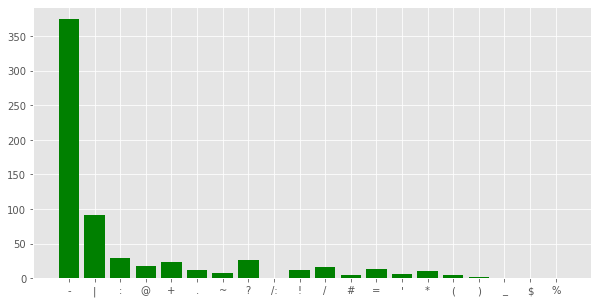

In [30]:
plt.figure(figsize=(10,5))
corpus=create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='green')

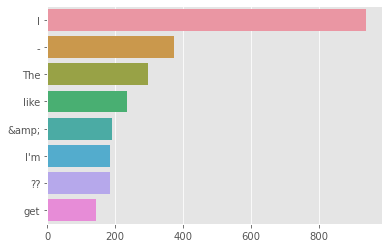

In [31]:
# Common words

counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)
sns.barplot(x=y,y=x)

## Ngram analysis

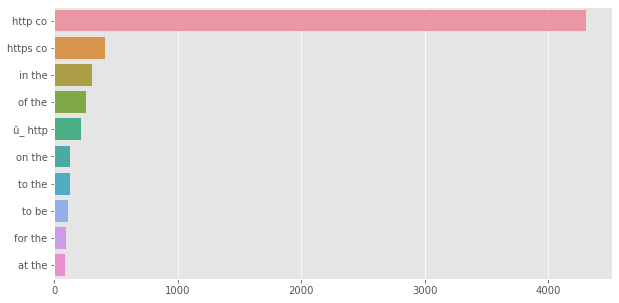

In [32]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(tweet['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

## Data Clean

In [33]:
df=pd.concat([tweet,test])
df.shape

(10876, 5)

In [34]:
example="New competition launched :https://www.kaggle.com/c/nlp-getting-started"

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

remove_URL(example)

'New competition launched :'

In [35]:
df['text']=df['text'].apply(lambda x : remove_URL(x))  # remove url

In [36]:
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
print(remove_html(example))


Real or Fake
Kaggle 
getting started



In [37]:
df['text']=df['text'].apply(lambda x : remove_html(x))  # remove tags

In [38]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")


'Omg another Earthquake '

In [39]:
df['text']=df['text'].apply(lambda x: remove_emoji(x))  # remove emoji

In [40]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

example="I am a #king"
print(remove_punct(example))

I am a king


In [41]:
df['text']=df['text'].apply(lambda x : remove_punct(x))

In [43]:
!pip install pyspellchecker

In [44]:
# spelling correct

from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
text = "corect me plese"
correct_spellings(text)
#df['text']=df['text'].apply(lambda x : correct_spellings(x)#)

'correct me please'

### GloVe for Vectorization

In [45]:
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [46]:
corpus=create_corpus(df)

100%|██████████████████████████████████████████████████████████████████████████| 10876/10876 [00:01<00:00, 8348.01it/s]


In [49]:
embedding_dict={}
with open('glove.txt','r', encoding='utf-8') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [52]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [53]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 20342


In [54]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|████████████████████████████████████████████████████████████████████████| 20342/20342 [00:00<00:00, 485418.38it/s]


## Baseline Model

In [55]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [56]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           2034300   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 2,076,605
Trainable params: 42,305
Non-trainable params: 2,034,300
_________________________________________________________________


In [57]:
train=tweet_pad[:tweet.shape[0]]
test=tweet_pad[tweet.shape[0]:]
X_train,X_test,y_train,y_test=train_test_split(train,tweet['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6471, 50)
Shape of Validation  (1142, 50)


In [58]:
history=model.fit(X_train,y_train,batch_size=4,epochs=15,validation_data=(X_test,y_test),verbose=2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 6471 samples, validate on 1142 samples
Epoch 1/15
6471/6471 - 119s - loss: 0.6915 - accuracy: 0.5698 - val_loss: 0.6896 - val_accuracy: 0.5709
Epoch 2/15
6471/6471 - 114s - loss: 0.6861 - accuracy: 0.5702 - val_loss: 0.6789 - val_accuracy: 0.5709
Epoch 3/15
6471/6471 - 113s - loss: 0.6462 - accuracy: 0.6130 - val_loss: 0.5922 - val_accuracy: 0.7356
Epoch 4/15
6471/6471 - 118s - loss: 0.5935 - accuracy: 0.7249 - val_loss: 0.5586 - val_accuracy: 0.7496
Epoch 5/15
6471/6471 - 117s - loss: 0.5776 - accuracy: 0.7311 - val_loss: 0.5466 - val_accuracy: 0.7539
Epoch 6/15
6471/6471 - 119s - loss: 0.5636 - accuracy: 0.7373 - val_loss: 0.5394 - val_accuracy: 0.7522
Epoch 7/15
6471/6471 - 122s - loss: 0.5687 - accuracy: 0.7367 - val_loss: 0.5321 - val_accuracy: 0.7557
Epoch 8/15
6471/6471 - 123s - loss: 0.5540 - accuracy: 0.7453 - val_loss: 0.5267 - val_accuracy: 0.7574
Epoch 9/15
6471/6471 - 117